In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv
/kaggle/input/bank-full/bank-full.csv
/kaggle/input/playground-series/sample_submission.csv
/kaggle/input/playground-series/train.csv
/kaggle/input/playground-series/test.csv


TRAIN SHAPE: (750000, 18)
TEST SHAPE: (250000, 17)

TARGET DISTRIBUTION:
y
0    0.879349
1    0.120651
Name: proportion, dtype: float64

MISSING VALUES (Train):
id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


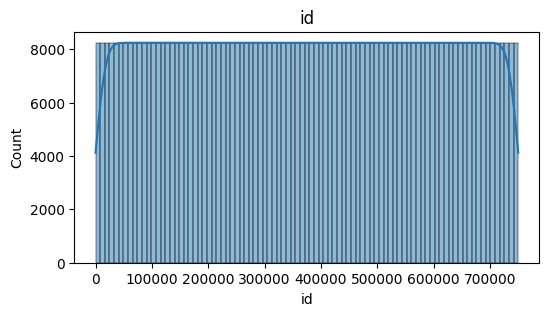

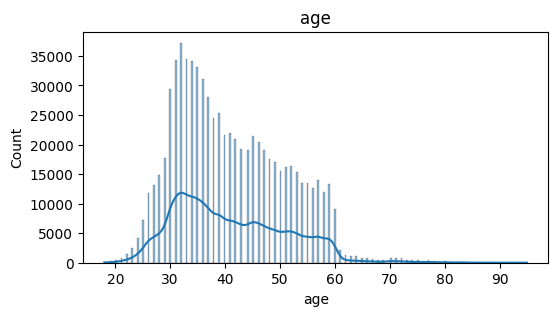

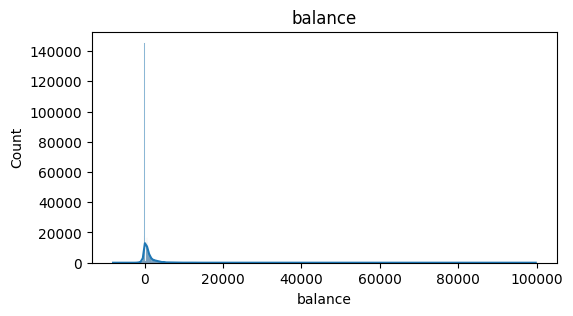

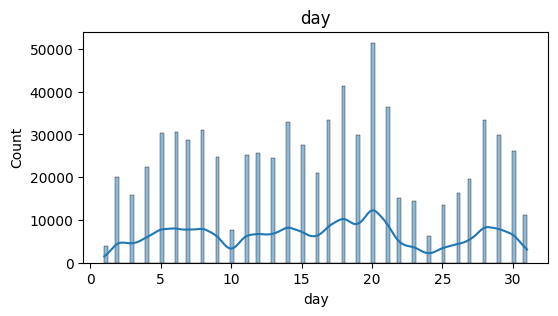

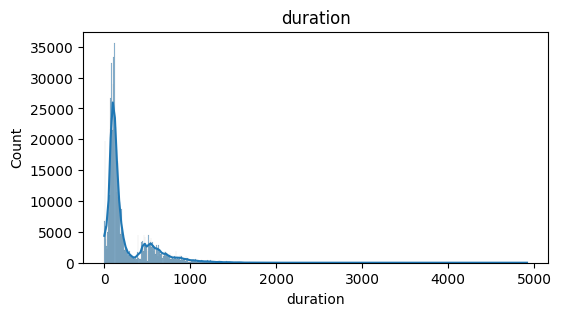

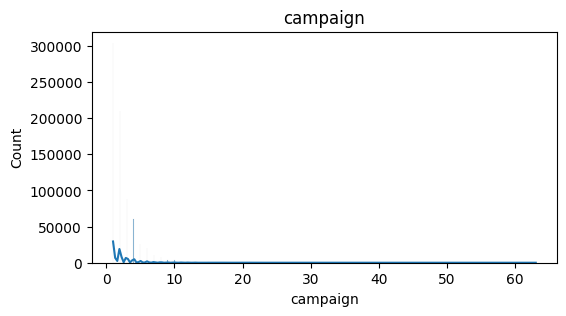

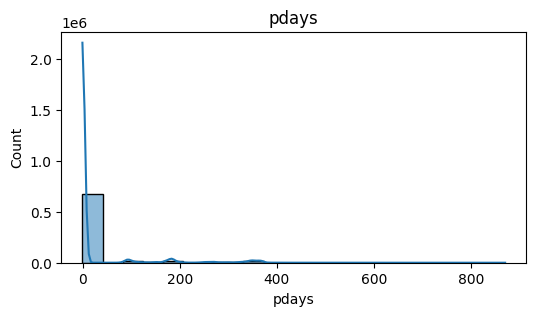

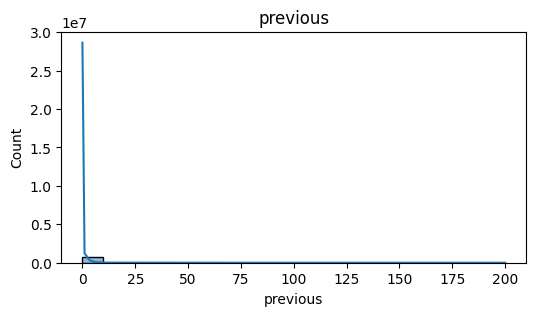

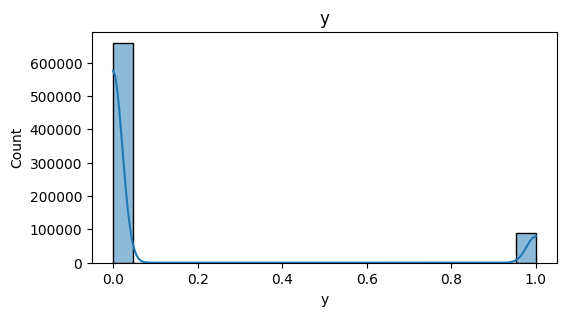

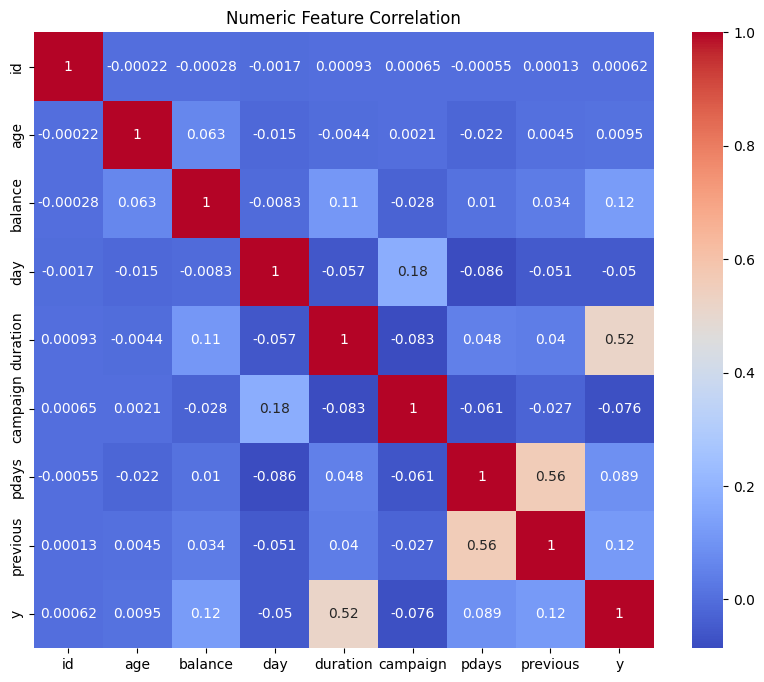

Final feature shape: (750000, 63)


In [10]:
# ---------------------- IMPORT LIBRARIES ----------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# ---------------------- LOAD DATA ----------------------
TRAIN_PATH = "/kaggle/input/playground-series-s5e8/train.csv"
TEST_PATH = "/kaggle/input/playground-series-s5e8/test.csv"
SAMPLE_SUB_PATH = "/kaggle/input/playground-series-s5e8/sample_submission.csv"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

TARGET = "y"

# ---------------------- EDA ----------------------
print("TRAIN SHAPE:", train.shape)
print("TEST SHAPE:", test.shape)
print("\nTARGET DISTRIBUTION:")
print(train[TARGET].value_counts(normalize=True))

# Check missing values
print("\nMISSING VALUES (Train):")
print(train.isnull().sum())

# Quick visualization for numeric features
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(train[col], kde=True)
    plt.title(col)
    plt.show()

# Check correlations
plt.figure(figsize=(10,8))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Numeric Feature Correlation")
plt.show()

# ---------------------- FEATURE ENGINEERING ----------------------
def feature_engineering(df):
    df = df.copy()
    
    # ------------------ NUMERIC FEATURES ------------------
    for col in df.select_dtypes(include=np.number).columns:
        if col not in ['y', 'id']:
            df[col+'_log'] = np.log1p(np.maximum(df[col], 0))
            df[col+'_sqrt'] = np.sqrt(np.maximum(df[col], 0))
            df[col+'_square'] = df[col]**2
    
    # Age groups
    if 'age' in df.columns:
        df['age_group'] = pd.cut(df['age'], bins=[0,25,35,45,55,65,100],
                                 labels=['young','adult','mid','senior','elder','old'])
        df['age_group'] = LabelEncoder().fit_transform(df['age_group'].astype(str))
        df['is_senior'] = (df['age']>=60).astype(int)
        df['is_young'] = (df['age']<=30).astype(int)
    
    # Balance features
    if 'balance' in df.columns:
        df['balance_pos'] = (df['balance']>0).astype(int)
        df['balance_neg'] = (df['balance']<0).astype(int)
        df['balance_zero'] = (df['balance']==0).astype(int)
        df['balance_log'] = np.log1p(np.abs(df['balance']))
    
    # Duration features
    if 'duration' in df.columns:
        df['duration_short'] = (df['duration']<300).astype(int)
        df['duration_long'] = (df['duration']>600).astype(int)
        df['duration_log'] = np.log1p(df['duration'])
        df['duration_min'] = df['duration']/60.0
    
    # Campaign features
    if 'campaign' in df.columns:
        df['campaign_high'] = (df['campaign']>3).astype(int)
        df['campaign_log'] = np.log1p(df['campaign'])
    
    # Previous features
    if 'previous' in df.columns:
        df['has_previous'] = (df['previous']>0).astype(int)
        df['previous_log'] = np.log1p(df['previous'])
    
    # Interaction features between categorical variables
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    if len(cat_cols)>=2:
        for i, c1 in enumerate(cat_cols[:5]):
            for c2 in cat_cols[i+1:6]:
                df[f'{c1}_{c2}_interaction'] = df[c1].astype(str)+'_'+df[c2].astype(str)
    
    return df

train_fe = feature_engineering(train)
test_fe = feature_engineering(test)

# ---------------------- CLEANING ----------------------
def clean_data(df):
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(0)
    return df

train_fe = clean_data(train_fe)
test_fe = clean_data(test_fe)

# ---------------------- CATEGORICAL ENCODING ----------------------
cat_cols = train_fe.select_dtypes(include='object').columns.tolist()
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_fe[col], test_fe[col]], axis=0).astype(str)
    le.fit(combined)
    train_fe[col] = le.transform(train_fe[col].astype(str))
    test_fe[col] = le.transform(test_fe[col].astype(str))
    label_encoders[col] = le

# ---------------------- FINAL FEATURES ----------------------
X = train_fe.drop([TARGET, 'id'], axis=1, errors='ignore')
y = train_fe[TARGET].astype(int)
X_test = test_fe.drop(['id'], axis=1, errors='ignore')

print("Final feature shape:", X.shape)



In [20]:
# ---------------------- MODELING (CV + ENSEMBLE) ----------------------
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

xgb_preds = np.zeros(X_test.shape[0])
lgb_preds = np.zeros(X_test.shape[0])
xgb_auc_list = []
lgb_auc_list = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}/{n_folds}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # XGBoost
    xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'   # keep this
    # remove use_label_encoder entirely
)

    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
     
        verbose=False
    )
    # XGBoost predictions for validation set
    xgb_val_pred = xgb_model.predict_proba(X_val)[:, 1]  # probability of positive class
    xgb_preds += xgb_model.predict_proba(X_test)[:, 1] / n_folds  # accumulate test predictions
    xgb_auc = roc_auc_score(y_val, xgb_val_pred)  # compute AUC
    xgb_auc_list.append(xgb_auc)

    
    # LightGBM
    
    lgb_model = lgb.LGBMClassifier(
    n_estimators=10000, learning_rate=0.01, max_depth=6,
    num_leaves=31, subsample=0.8, colsample_bytree=0.8,
    random_state=42
)

    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

    lgb_val_pred = lgb_model.predict_proba(X_val)[:,1]
    lgb_preds += lgb_model.predict_proba(X_test)[:,1]/n_folds
    lgb_auc = roc_auc_score(y_val, lgb_val_pred)
    lgb_auc_list.append(lgb_auc)
    
    print(f"XGB AUC: {xgb_auc:.5f}, LGB AUC: {lgb_auc:.5f}")

print(f"\nMean XGB AUC: {np.mean(xgb_auc_list):.5f}")
print(f"Mean LGB AUC: {np.mean(lgb_auc_list):.5f}")

# ---------------------- ENSEMBLE ----------------------
xgb_weight = np.mean(xgb_auc_list)/(np.mean(xgb_auc_list)+np.mean(lgb_auc_list))
lgb_weight = np.mean(lgb_auc_list)/(np.mean(xgb_auc_list)+np.mean(lgb_auc_list))
final_pred = xgb_weight*xgb_preds + lgb_weight*lgb_preds
print(f"Ensemble Weights - XGB: {xgb_weight:.3f}, LGB: {lgb_weight:.3f}")

# ---------------------- SUBMISSION ----------------------
submission = sample_sub.copy()
submission['y'] = final_pred
submission.to_csv("submission_ensemble.csv", index=False)
print("Submission saved as 'submission_ensemble.csv'")


Fold 1/5
[LightGBM] [Info] Number of positive: 72391, number of negative: 527609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4373
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120652 -> initscore=-1.986273
[LightGBM] [Info] Start training from score -1.986273
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [5]:
pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
